In [1]:
# importing all necessary libraries: including pytorch, sklearn, cv2, PIL etc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.neighbors import NearestNeighbors

import torch
from torch import nn
from torch import optim

import cv2
import os
from PIL import Image

In [2]:
# setting base url of kaggle image folder
path = '/kaggle/input/images-dataset/'

# loading the file names data into a dataframe
df = pd.read_csv(path + "validatefile.csv", index_col=0)

In [3]:
df.head() # printing head of the image names in dataframe df

,image_a,image_b
0,5452,11467
1,224,6239
2,2264,8279
3,3218,9233
4,4495,10510


In [5]:
def draw_pair_image_similar(df, idx):
    # setting dimensions tuple for preprocessing the image
    dim = (200,200)
    # loading and precprocessing the first image
    img_1 = cv2.imread(path+'imagesdata/'+str(df.iloc[idx]['image_a'])+'.jpg')
    img_1 = cv2.resize(img_1, dim, interpolation=cv2.INTER_AREA)
    # for second image preprocessing
    img_2 = cv2.imread(path+'imagesdata/'+str(df.iloc[idx]['image_b'])+'.jpg')
    img_2 = cv2.resize(img_2, dim, interpolation=cv2.INTER_AREA)
    # collecting both images into list
    imgs = [img_1,img_2]

    f,ax=plt.subplots(1,2,figsize=(12,12)) #initialising the plot for showing them
    for ix,img in enumerate(imgs):
        ax[ix].imshow(img)
        ax[ix].axis('off')

    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()

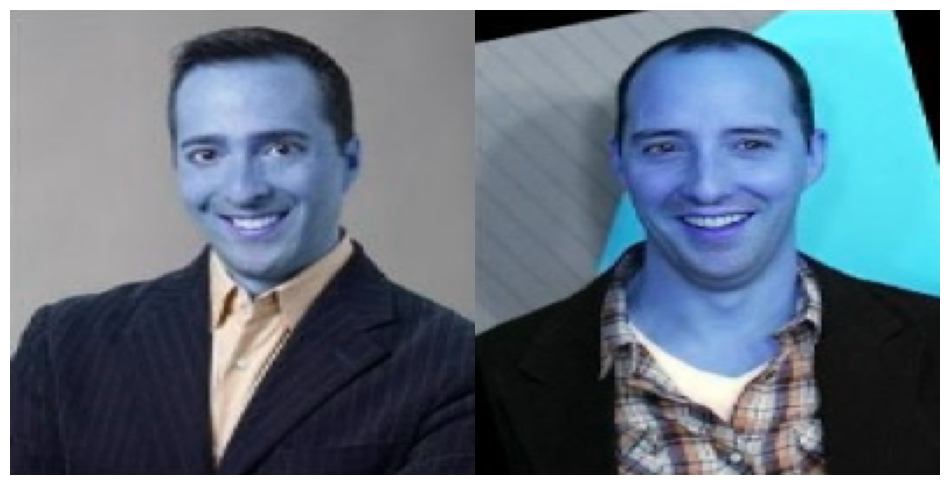

In [40]:
draw_pair_image_similar(df, 1)

In [7]:
class AlikeDataset(Dataset):

    def __init__(self, path, transform=None):
        self.path = path + 'imagesdata/'
        self.files = self.absolute_file_paths(self.path)
        self.transform = transform
        
    def absolute_file_paths(self, directory):
        path = os.path.abspath(directory)
        return [entry.path for entry in os.scandir(path) if entry.is_file()]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):

        img_path = self.files[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)
            return tensor_image, tensor_image
        
        return image

In [8]:
# creating transformers
transforms = T.Compose([T.Resize((352, 128)),
                        T.ToTensor()]
                      )
# create dataset
alike_ds = AlikeDataset(path, transforms)

In [9]:
# Calculate the size of the training dataset (75% of the total dataset)
train_size = int(len(alike_ds) * 0.75)

# Calculate the size of the validation dataset (remaining 25%)
val_size = len(alike_ds) - train_size

# Split the dataset into training and validation sets using random_split
# - 'alike_ds' is the original dataset
# - 'train_size' is the number of samples in the training set
# - 'val_size' is the number of samples in the validation set
train_dataset, val_dataset = torch.utils.data.random_split(alike_ds, [train_size, val_size])

# Create a DataLoader for the training dataset
# - 'train_dataset' is the dataset to load
# - 'batch_size=32' specifies the number of samples per batch
# - 'shuffle=True' ensures the data is shuffled at every epoch
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create a DataLoader for the validation dataset
# - 'val_dataset' is the dataset to load
# - 'batch_size=32' specifies the number of samples per batch
# - 'shuffle' is False by default (no shuffling needed for validation data)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# Create a DataLoader for the entire dataset (if needed for specific use cases, e.g., evaluation or visualization)
# - 'alike_ds' is the full dataset
# - 'batch_size=32' specifies the number of samples per batch
# - Data is not shuffled because it might not be required for the entire dataset
full_loader = torch.utils.data.DataLoader(alike_ds, batch_size=32)

Here is the code for encoder

In [10]:
class ConvEncoder(nn.Module):
    # A simple Convolutional Encoder Model for feature extraction using 5 convolutional layers.
    

    def __init__(self):
        super().__init__()
        
        # First convolutional block: input channels = 3 (RGB image), output channels = 16
        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))  # 3x3 filter, preserves spatial size
        self.relu1 = nn.ReLU(inplace=True)                     # Activation function
        self.maxpool1 = nn.MaxPool2d((2, 2))                   # Downsampling by 2x

        # Second convolutional block: increases channels to 32
        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        # Third convolutional block: increases channels to 64
        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

        # Fourth convolutional block: increases channels to 128
        self.conv4 = nn.Conv2d(64, 128, (3, 3), padding=(1, 1))
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d((2, 2))

        # Fifth convolutional block: increases channels to 256
        self.conv5 = nn.Conv2d(128, 256, (3, 3), padding=(1, 1))
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Pass input through each convolutional block sequentially
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.conv4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.conv5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)
        
        return x  # Return the final encoded feature representation


What does the cell below is doing

    The computation is set to run on a GPU (cuda) for faster processing.
    The loss function is defined as Mean Squared Error, suitable for comparing reconstructed outputs to inputs.
    The encoder and decoder models are instantiated and moved to the GPU.
    The trainable parameters of both models are combined into a single list.
    The Adam optimizer is configured to update these parameters during training with a learning rate of 0.001.

In [11]:
class ConvDecoder(nn.Module):
    
    # A simple Convolutional Decoder Model for upsampling and reconstructing data from encoded features.

    def __init__(self):
        super().__init__()

        # First transposed convolutional block: reduces channels from 256 to 128
        # - Upsamples spatial dimensions by a factor of 2 (stride=(2, 2))
        self.deconv1 = nn.ConvTranspose2d(256, 128, (2, 2), stride=(2, 2))
        self.relu1 = nn.ReLU(inplace=True)  # Activation function

        # Second transposed convolutional block: reduces channels from 128 to 64
        # - Continues upsampling spatial dimensions by a factor of 2
        self.deconv2 = nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2))
        self.relu2 = nn.ReLU(inplace=True)

        # Third transposed convolutional block: reduces channels from 64 to 32
        # - Further upsamples the spatial dimensions
        self.deconv3 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        self.relu3 = nn.ReLU(inplace=True)

        # Fourth transposed convolutional block: reduces channels from 32 to 16
        # - Spatial dimensions are upsampled again
        self.deconv4 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
        self.relu4 = nn.ReLU(inplace=True)

        # Fifth transposed convolutional block: reduces channels from 16 to 3
        # - Final layer to reconstruct the original number of channels (e.g., RGB image)
        # - Spatial dimensions are fully upsampled to match the original input size
        self.deconv5 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
        # Pass input through each transposed convolutional block sequentially
        x = self.deconv1(x)
        x = self.relu1(x)

        x = self.deconv2(x)
        x = self.relu2(x)

        x = self.deconv3(x)
        x = self.relu3(x)

        x = self.deconv4(x)
        x = self.relu4(x)

        x = self.deconv5(x)
        x = self.relu5(x)

        return x  # Return the reconstructed output

In [12]:
device = "cuda" # for using GPUs
loss_fn = nn.MSELoss()

encoder = ConvEncoder().to(device)
decoder = ConvDecoder().to(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(autoencoder_params, lr=1e-3)

In [13]:
 def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
  
    # Set both encoder and decoder to training mode
    encoder.train()
    decoder.train()

    # Iterate through each batch in the training data
    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        # Move input images (train_img) and target images (target_img) to the specified device (e.g., GPU)
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        
        # Clear gradients from the previous batch (avoids accumulation of gradients)
        optimizer.zero_grad()

        # Forward pass through the encoder
        enc_output = encoder(train_img)

        # Forward pass through the decoder to reconstruct the images
        dec_output = decoder(enc_output)
        
        # Compute the loss between the reconstructed images and the target images
        loss = loss_fn(dec_output, target_img)

        # Backpropagate the loss to compute gradients
        loss.backward()

        # Update the model parameters using the optimizer
        optimizer.step()

    # Return the loss value as a scalar for monitoring
    return loss.item()


In [14]:
def val_step(encoder, decoder, val_loader, loss_fn, device):
    
    # Set both encoder and decoder to evaluation mode
    # This disables certain behaviors like Dropout or BatchNorm updates
    encoder.eval()
    decoder.eval()
    
    # Disable gradient computations for validation to save memory and computation
    with torch.no_grad():
        # Iterate through the validation dataset batch by batch
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            
            # Move input images (train_img) and target images (target_img) to the specified device (e.g., GPU)
            train_img = train_img.to(device)
            target_img = target_img.to(device)
            
            # Forward pass through the encoder
            enc_output = encoder(train_img)
            
            # Forward pass through the decoder to reconstruct the images
            dec_output = decoder(enc_output)
            
            # Compute the loss between the reconstructed images and the target images
            loss = loss_fn(dec_output, target_img)
    
    # Return the loss value as a scalar for monitoring during validation
    return loss.item()


In [15]:
# Initialize lists to store training and validation losses for each epoch
train_losses, val_losses = [], []

# Loop through 10 epochs to train and validate the model
for epoch in range(10):
    
    # Perform a single training step and obtain the training loss
    train_loss = train_step(encoder, decoder, train_loader, loss_fn, optimizer, device=device)
    
    # Append the training loss of the current epoch to the `train_losses` list
    train_losses.append(train_loss)
    
    # Perform a single validation step and obtain the validation loss
    val_loss = val_step(encoder, decoder, val_loader, loss_fn, device=device)
    
    # Append the validation loss of the current epoch to the `val_losses` list
    val_losses.append(val_loss)
    
    # Print the epoch number, training loss, and validation loss at every 10th epoch
    if epoch % 10 == 0:
        print("Epoch:{0:3d}, Train_Loss:{1:1.3f}, Valid_Loss:{2:1.3f}"
              .format(epoch, train_loss, val_loss))

Epoch:  0, Train_Loss:0.023, Valid_Loss:0.023


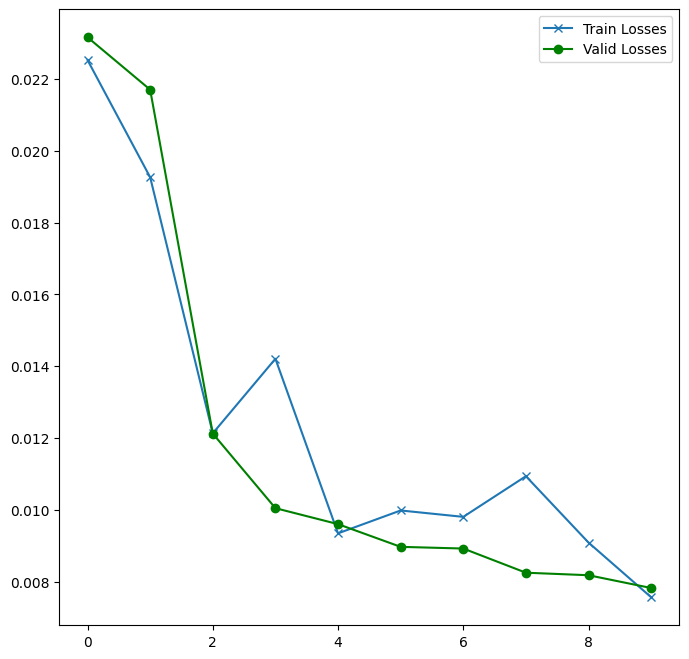

In [18]:
# plotting the losses for better understanding
plt.figure(figsize=(8,8))
plt.plot(train_losses, '-x', label='Train Losses')
plt.plot(val_losses, 'g-o', label='Valid Losses')
plt.legend()

In [20]:
def create_embedding(encoder, full_loader, embedding_dim, device):

    encoder.eval()

    embedding = torch.randn(embedding_dim)
    
    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            embedding = torch.cat((embedding, enc_output), 0)
    
    return embedding

code is useful for generating a large set of embeddings that can later be used for tasks such as clustering

In [21]:
embedding_shape = (1, 256, 11, 4)
embeddings = create_embedding(encoder, full_loader, embedding_shape, device)

This following function takes an image tensor, finds its embedding using the encoder model, and uses a KNN algorithm to find the most similar images in a set of embeddings. The result is the index of the closest image, based on cosine similarity between embeddings.

In [22]:
def get_similar_image_idx(image_tensor, num_images, embeddings, device):
    """
    Given an image tensor and the number of similar images to search,
    returns the indices of the num_images closest (most similar) images.
    """
    
    # Add a batch dimension to the input image tensor (convert to batch of size 1)
    image_tensor = image_tensor.unsqueeze(0)
    
    # Convert image_tensor to a FloatTensor for GPU compatibility (if using GPU)
    image_tensor = image_tensor.type(torch.cuda.FloatTensor)
    
    # Disable gradient calculation and pass the image through the encoder to get its embedding
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()  # Convert to numpy for KNN

    # Flatten the embedding to 1D vector to match the shape of embeddings for comparison
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    # Initialize K-Nearest Neighbors model with cosine distance metric to find closest embeddings
    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    
    # Fit the KNN model on the flattened embeddings (flatten all embeddings to 1D vectors)
    knn.fit(embeddings.reshape(embeddings.shape[0], -1))

    # Find the indices of the most similar images based on cosine similarity
    _, indices = knn.kneighbors(flattened_embedding)

    # Convert the result to a list of indices and return the first index (closest image)
    indices_list = indices.tolist()
    return indices_list[0][0]

# change the value of this img_idx, to check the values of similar image

In [37]:
img_idx = 0
similar_idx = get_similar_image_idx(alike_ds[img_idx][0], 1, embeddings, device)


In [38]:
def draw_similar_idx(df, img_idx, similar_idx):
    imgs = [df[img_idx][0].permute(1, 2, 0), df[similar_idx][0].permute(1, 2, 0)]
    f, ax = plt.subplots(1, 2, figsize=(12, 12))
    for ix, img in enumerate(imgs):
        ax[ix].imshow(img)
        ax[ix].axis('off')

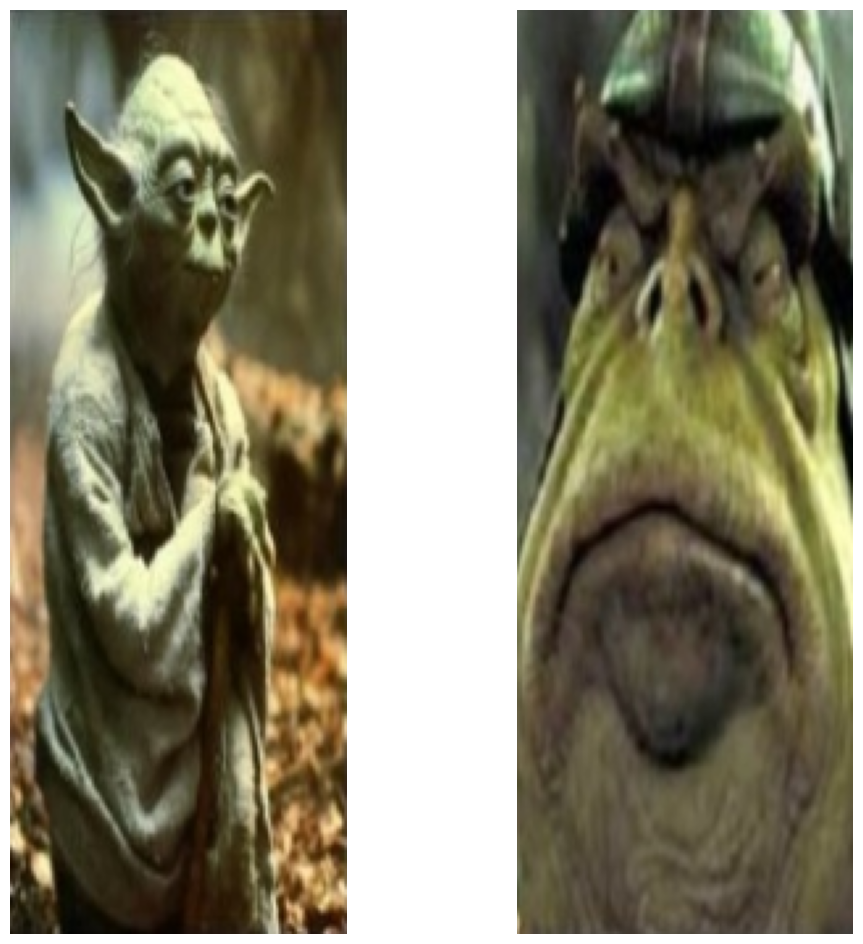

In [39]:
draw_similar_idx(alike_ds, img_idx, similar_idx)

# End of the code